# Reconnaissance du locuteur (Chirac/Mitterrand)

<b> SOYKOK Aylin 28711545 - CELIK Simay 28713301 </b>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import string
import nltk
from nltk.stem.snowball import FrenchStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from utils_donnee import *
from evaluation import *
from nltk.corpus import stopwords

In [2]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

In [3]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


### Distribution des labels

classe 1: Chirac <br>
classe -1: Miterrand

In [4]:
count_chirac = alllabs.count(1)
count_mitterrand = alllabs.count(-1)
print("Nombre de labels Chirac:", count_chirac)
print("Nombre de labels Mitterrand:", count_mitterrand)

Nombre de labels Chirac: 49890
Nombre de labels Mitterrand: 7523


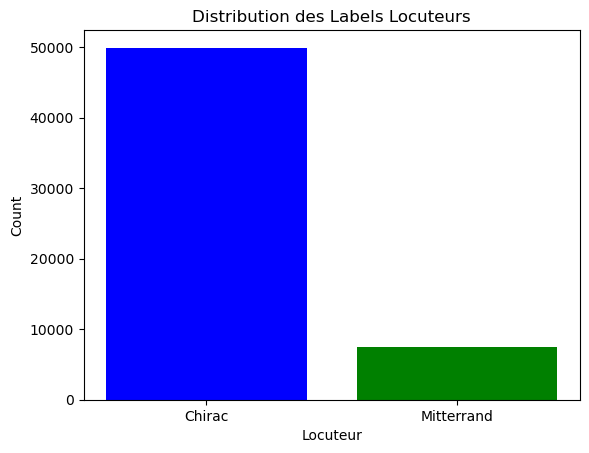

In [5]:
# Visualisation

labels = ['Chirac', 'Mitterrand']
counts = [count_chirac, count_mitterrand]

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Locuteur')
plt.ylabel('Count')
plt.title('Distribution des Labels Locuteurs')
plt.show()

<b> Les labels sont déséquilibrés. Il y a beaucoup de Chirac et peu de Miterrand. </b>

# A) Transformation paramétrique du texte (pre-traitements)

### suppression de la ponctuation

In [6]:
# test
example = alltxts[0]
example_no_ponc = ponc_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression de la ponctuation:")
print(example_no_ponc)

Texte originale:
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.


Texte après suppression de la ponctuation:
 Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  


On ne fait pas de transformation en minuscule car il y a des noms propres.

### suppression chiffres

In [7]:
# test
example = alltxts[1336]
example_no_chiffre = chiffre_suppression(example)
print("Texte originale:")
print(example)
print("\nTexte après suppression des chiffres:")
print(example_no_chiffre)

Texte originale:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la législature précédente, il y avait 10000 chômeurs de plus par moi, ce qui n'était pas fameux.


Texte après suppression des chiffres:
 Un ancien chef de gouvernement observait il y a quelques jours, que sous la législature précédente, il y avait  chômeurs de plus par moi, ce qui n'était pas fameux.



### transformation des mots entièrement en majuscule en marqueurs spécifiques

In [8]:
# test
text = ponc_suppression(alltxts[2467]) # on supprime la ponctuation d'abord car sinon il donne une erreur
marker = "<UPPER>"
new_text = transform_uppercase(text, marker)
print("Texte originale:")
print(text)
print("Texte après transformation:")
print(new_text)

Texte originale:
 Les études de l OMS et de l ONUSIDA le démontrent   l épidémie s étend  en Asie  en Russie  dans les pays de la CEI  dans les pays d Europe centrale et orientale  
Texte après transformation:
Les études de l <UPPER> et de l <UPPER> le démontrent l épidémie s étend en Asie en Russie dans les pays de la <UPPER> dans les pays d Europe centrale et orientale


### suppression des balises

In [9]:
# test
# on trouve les numéros des lignes qui contiennent des balises
def find_lines_with_tags(texts):
    lines_with_tags = []
    for i, text in enumerate(texts):
        if re.search(r'<[^>]+>', text):
            lines_with_tags.append(i)
    return lines_with_tags

lines_with_tags = find_lines_with_tags(alltxts)
lines_with_tags

[4,
 38,
 39,
 40,
 43,
 132,
 165,
 168,
 173,
 195,
 210,
 240,
 279,
 280,
 286,
 295,
 296,
 352,
 353,
 382,
 399,
 402,
 410,
 411,
 415,
 419,
 420,
 431,
 440,
 444,
 445,
 452,
 457,
 459,
 463,
 476,
 484,
 497,
 501,
 509,
 518,
 525,
 531,
 534,
 536,
 540,
 544,
 573,
 591,
 629,
 650,
 651,
 682,
 702,
 703,
 761,
 827,
 830,
 839,
 848,
 852,
 855,
 856,
 857,
 859,
 861,
 863,
 876,
 877,
 887,
 888,
 889,
 890,
 891,
 893,
 894,
 897,
 898,
 904,
 907,
 936,
 937,
 940,
 980,
 1026,
 1036,
 1044,
 1046,
 1110,
 1115,
 1120,
 1123,
 1128,
 1130,
 1147,
 1162,
 1166,
 1213,
 1242,
 1244,
 1245,
 1292,
 1401,
 1404,
 1443,
 1446,
 1450,
 1455,
 1457,
 1467,
 1470,
 1483,
 1487,
 1497,
 1556,
 1557,
 1563,
 1597,
 1603,
 1623,
 1674,
 1682,
 1730,
 1738,
 1739,
 1757,
 1766,
 1785,
 1790,
 1794,
 1831,
 1839,
 1840,
 1868,
 1870,
 1871,
 1881,
 1890,
 1924,
 1937,
 1942,
 1958,
 1959,
 1961,
 1982,
 1985,
 1997,
 2049,
 2065,
 2094,
 2095,
 2108,
 2116,
 2119,
 2120,
 2121

In [10]:
text_balise = alltxts[38]
sans_balise = remove_tags(text_balise)
print("Texte originale:")
print(text_balise)
print("Texte après transformation:")
print(sans_balise)

Texte originale:
 Je lève mon verre en l'honneur du <nom> , Président de la République du Congo, en l'honneur de <nom> , en l'honneur du Congo ami de la France.

Texte après transformation:
 Je lève mon verre en l'honneur du  , Président de la République du Congo, en l'honneur de  , en l'honneur du Congo ami de la France.



In [11]:
text_balise2 = alltxts[132]
sans_balise2 = remove_tags(text_balise2)
print("Texte originale:")
print(text_balise2)
print("Texte après transformation:")
print(sans_balise2)

Texte originale:
 Nous sommes convenus d'organiser, en <date>, une "Année du Maroc" en France, série de grandes manifestations culturelles et technologiques, qui permettra de mieux faire connaître le Maroc, ses traditions, mais aussi sa modernité dans toutes les villes de notre pays.

Texte après transformation:
 Nous sommes convenus d'organiser, en , une "Année du Maroc" en France, série de grandes manifestations culturelles et technologiques, qui permettra de mieux faire connaître le Maroc, ses traditions, mais aussi sa modernité dans toutes les villes de notre pays.



### stemming

In [12]:
# test
text_test = alltxts[840]
stemmed = stem(text_test)
print("Texte originale:")
print(text_test)
print("Texte après stemmatisation:")
print(stemmed)

Texte originale:
 La lumière y est plus vive ".

Texte après stemmatisation:
la lumi y est plus viv `` .


In [13]:
text_test = alltxts[1823]
stemmed = stem(text_test)
print("Texte originale:")
print(text_test)
print("Texte après stemmatisation:")
print(stemmed)

Texte originale:
 D'ambition pour elle-même, d'ambition pour le monde.

Texte après stemmatisation:
d'ambit pour elle-mêm , d'ambit pour le mond .


# B) Extraction du vocabulaire (BoW)

### la taille d'origine du vocabulaire

In [14]:
vectorizer = CountVectorizer() #no preprocessing
X = vectorizer.fit_transform(alltxts)
vocabulary = vectorizer.vocabulary_
print("taille originale du vocab :",len(vocabulary))

taille originale du vocab : 28524


### 100 mots les plus fréquents

In [15]:
max_features = 100
vectorizer =  CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(alltxts)
dic_size = X.shape[1]###

words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))
print(dic_size)
print(words)

100
['ai' 'au' 'aujourd' 'aussi' 'autres' 'aux' 'avec' 'avez' 'avons' 'bien'
 'ce' 'cela' 'ces' 'cette' 'ceux' 'chacun' 'comme' 'dans' 'date' 'de'
 'depuis' 'des' 'deux' 'dire' 'doit' 'dont' 'du' 'développement' 'elle'
 'en' 'encore' 'ensemble' 'entre' 'est' 'et' 'etat' 'europe' 'faire'
 'fait' 'faut' 'france' 'français' 'hui' 'ici' 'il' 'ils' 'je' 'la' 'le'
 'les' 'leur' 'leurs' 'mais' 'monde' 'monsieur' 'même' 'ne' 'nom' 'nos'
 'notre' 'nous' 'on' 'ont' 'ou' 'où' 'paix' 'par' 'pas' 'pays' 'peut'
 'plus' 'politique' 'pour' 'président' 'qu' 'que' 'qui' 'sa' 'sans' 'se'
 'ses' 'si' 'son' 'sont' 'sur' 'temps' 'tous' 'tout' 'toute' 'toutes'
 'très' 'un' 'une' 'union' 'vie' 'vos' 'votre' 'vous' 'été' 'être']


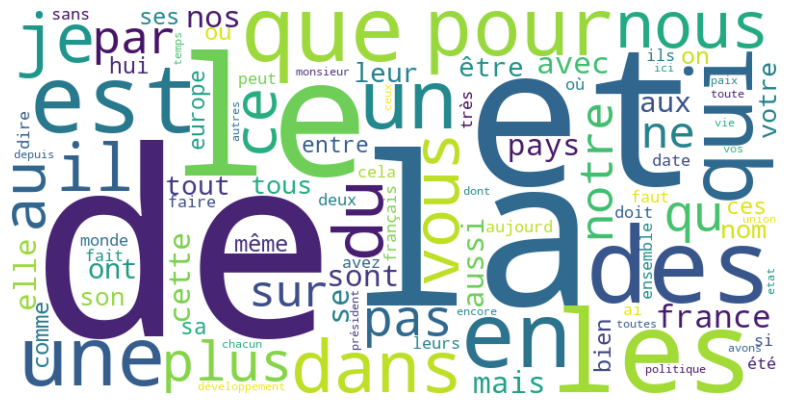

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 100 mots les plus discriminants au sens de odds ratio

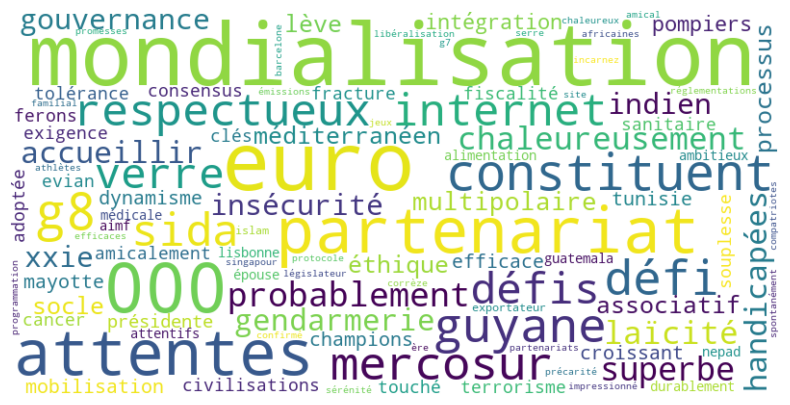

In [17]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)
clf = MultinomialNB()
clf.fit(X, alllabs)
log_probabilities = clf.feature_log_prob_
odds_ratios = np.exp(log_probabilities[1] - log_probabilities[0])
words = vectorizer.get_feature_names_out()
word_odds_ratios = dict(zip(words, odds_ratios))
sorted_word_odds_ratios = sorted(word_odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_words = dict(sorted_word_odds_ratios[:100])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### distribution d'apparition des mots (Zipf)

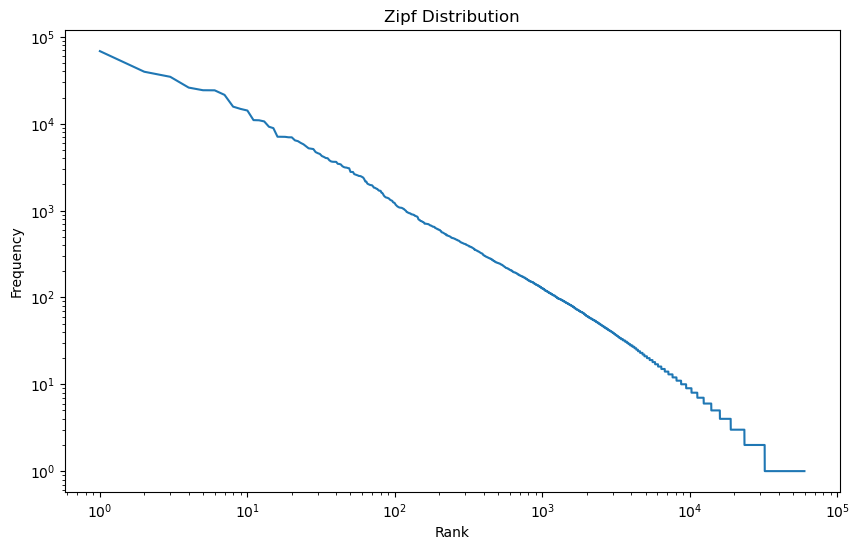

In [18]:
words = [word for text in alltxts for word in text.split()]
word_freq = Counter(words)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [freq for word, freq in sorted_word_freq]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frequencies) + 1), frequencies)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf Distribution')
plt.xscale('log')
plt.yscale('log')
plt.show()

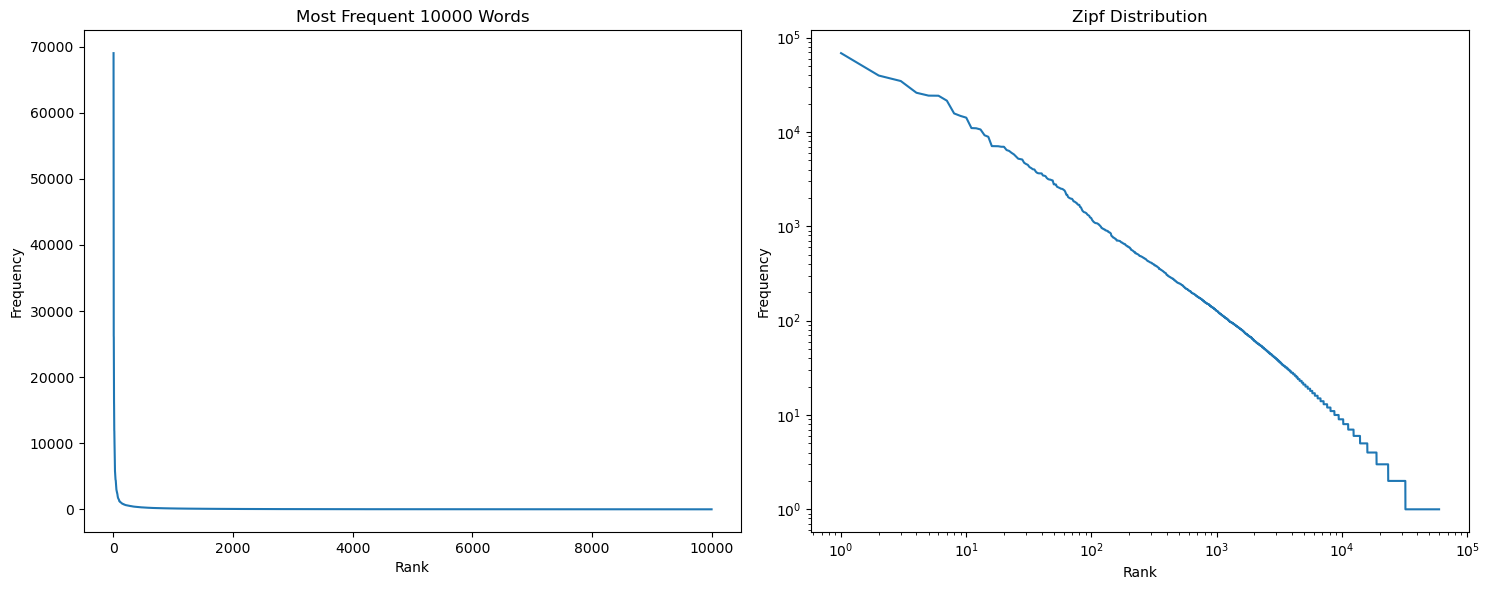

In [19]:
# Most frequent 100000 words vs Zipf Law

max_features = 10000
vectorizer =  CountVectorizer(max_features=max_features)
X = vectorizer.fit_transform(alltxts)
dic_size = X.shape[1]
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
words_sorted, frequencies_sorted = zip(*sorted_word_freq)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(range(1, len(words_sorted) + 1), list(frequencies_sorted))
axs[0].set_title('Most Frequent 10000 Words')
axs[0].set_xlabel('Rank')
axs[0].set_ylabel('Frequency')

# Zipf
axs[1].plot(range(1, len(frequencies) + 1), frequencies)
axs[1].set_title('Zipf Distribution')
axs[1].set_xlabel('Rank')
axs[1].set_ylabel('Frequency')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

### 100 Bigrammes les plus fréquents

In [20]:
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100)
X_ngrams = ngram_vectorizer.fit_transform(alltxts)
ngram_names = ngram_vectorizer.get_feature_names_out()
ngram_freq = X_ngrams.sum(axis=0).A1

ngram_freq_dict = dict(zip(ngram_names, ngram_freq))
sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_100_bigrams = sorted_ngrams[:100]
for ngram, freq in top_100_bigrams:
    print(f"{ngram}: {freq}")

de la: 11951
et de: 4385
la france: 4091
aujourd hui: 2581
dans le: 2297
et la: 2195
qu il: 1983
de notre: 1932
de nos: 1753
il faut: 1722
tous les: 1653
dans la: 1625
et les: 1614
que nous: 1610
vous avez: 1588
monsieur le: 1507
que la: 1395
dans les: 1361
nous avons: 1320
que vous: 1304
il est: 1276
et des: 1269
qui est: 1260
que les: 1216
et le: 1201
le président: 1160
et je: 1156
pour la: 1119
est pas: 1108
et qui: 1079
ce qui: 1065
ceux qui: 1044
ce que: 1024
que je: 1024
sur le: 1024
qui ont: 1013
est un: 993
de ce: 969
nous devons: 959
de votre: 955
du monde: 955
de cette: 951
le monde: 950
qu elle: 941
sur la: 909
par la: 903
que le: 899
est une: 895
pour les: 873
de ses: 856
je suis: 854
est la: 835
les plus: 832
la paix: 817
notre pays: 791
qu ils: 789
toutes les: 780
est le: 777
la vie: 764
doit être: 763
de ces: 756
par le: 742
mais aussi: 737
je voudrais: 728
de son: 723
sur les: 718
de leur: 710
de tous: 703
elle est: 702
qui sont: 680
la république: 674
je le: 664
union 

### 100 trigrammes les plus fréquents

In [21]:
ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=100)
X_ngrams = ngram_vectorizer.fit_transform(alltxts)
ngram_names = ngram_vectorizer.get_feature_names_out()
ngram_freq = X_ngrams.sum(axis=0).A1

ngram_freq_dict = dict(zip(ngram_names, ngram_freq))
sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)
top_100_trigrams = sorted_ngrams[:100]
for ngram, freq in top_100_trigrams:
    print(f"{ngram}: {freq}")

de la france: 954
monsieur le président: 923
et de la: 765
dans le monde: 516
de la république: 478
mesdames et messieurs: 448
la france est: 395
et la france: 392
que la france: 385
ce est pas: 380
que vous avez: 380
de la vie: 373
de plus en: 356
plus en plus: 355
de tous les: 343
nos deux pays: 336
dans le domaine: 309
la france et: 307
au service de: 298
dans le cadre: 290
de la paix: 288
de notre pays: 277
que nous avons: 277
je suis heureux: 265
de union européenne: 257
ce qui est: 256
droits de homme: 247
la mise en: 247
monsieur le maire: 245
je souhaite que: 244
tous ceux qui: 242
sur le plan: 239
la lutte contre: 238
de la démocratie: 235
vous le savez: 230
président de la: 229
au sein de: 224
entre nos deux: 215
ne sont pas: 214
de la communauté: 206
je sais que: 205
le respect de: 205
ceux qui ont: 202
les moyens de: 201
au nom de: 200
de la nation: 200
en même temps: 199
au delà de: 196
est aujourd hui: 195
qu il faut: 195
de ceux qui: 192
des droits de: 192
au coeur de: 1

### Stopwords

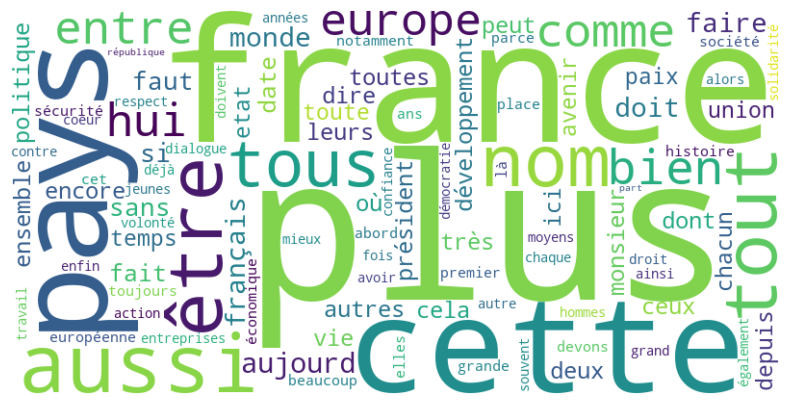

In [22]:
# les 100 mots les plus fréquents après sans considérer les stopwords
#nltk.download('stopwords')
from nltk.corpus import stopwords
max_features = 100
vectorizer = CountVectorizer(max_features=max_features, stop_words=stopwords.words('french'))
X = vectorizer.fit_transform(alltxts)
words = vectorizer.get_feature_names_out()
word_freq = dict(zip(words, X.sum(axis=0).A1))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Variantes de BoW

### CountVectorizer

In [24]:
# test avec suppresion de ponctuation
count_vec=create_count_vectorizer(preprocessor=ponc_suppression)
count_vec

CountVectorizer(preprocessor=<function ponc_suppression at 0x0000020F8FFEB100>)

### TfidfVectorizer

test avec suppression de la ponctuation

In [6]:
preprocessor = ponc_suppression
vect_params = {}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8987198467299486
F1 Score (weighted): 0.8779686219900295
F1 Score: 0.944346078384457
F1 Score sur Mitterrand (minoritaire): 0.43789270178830353
Precision (weighted): 0.890487207817638
ROC AUC (weighted): 0.6449361019492053
ROC AUC sur Mitterrand (minoritaire): 0.11590855363527336
AP sur Mitterrand (minoritaire): 0.7216848748424519


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test avec suppression de la ponctuation et des chiffres

In [7]:
preprocessor = lambda text: chiffre_suppression(ponc_suppression(text))
vect_params = {}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8983715057040843
F1 Score (weighted): 0.8774150002570729
F1 Score: 0.9441653509401465
F1 Score sur Mitterrand (minoritaire): 0.43486682808716703
Precision (weighted): 0.8900154155374305
ROC AUC (weighted): 0.6436071982947201
ROC AUC sur Mitterrand (minoritaire): 0.11642953367841144
AP sur Mitterrand (minoritaire): 0.7218422259440649


test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises

In [8]:
preprocessor = lambda text: remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8985456762170164
F1 Score (weighted): 0.8776919954723814
F1 Score: 0.9442557060146419
F1 Score sur Mitterrand (minoritaire): 0.43638122883405905
Precision (weighted): 0.8902516131868579
ROC AUC (weighted): 0.6442716501219627
ROC AUC sur Mitterrand (minoritaire): 0.11703698302378189
AP sur Mitterrand (minoritaire): 0.7220086405065


test avec suppression de la ponctuation et des chiffres, supression des balises, stemming

In [9]:
preprocessor = lambda text: stem(remove_tags(chiffre_suppression(ponc_suppression(text))))
vect_params = {}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8964556300618305
F1 Score (weighted): 0.8749670539757702
F1 Score: 0.9431236546280793
F1 Score sur Mitterrand (minoritaire): 0.4230955846676371
Precision (weighted): 0.8867039565179877
ROC AUC (weighted): 0.6388372692348415
ROC AUC sur Mitterrand (minoritaire): 0.12943292519289945
AP sur Mitterrand (minoritaire): 0.7257020318948342


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises, stemming

In [10]:
preprocessor = lambda text: stem(remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text)))))
vect_params = {}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

Accuracy: 0.8966298005747627
F1 Score (weighted): 0.8751773701171062
F1 Score: 0.9432193255202104
F1 Score sur Mitterrand (minoritaire): 0.42406598738476475
Precision (weighted): 0.8870192038786917
ROC AUC (weighted): 0.6392196053909964
ROC AUC sur Mitterrand (minoritaire): 0.13026984948281567
AP sur Mitterrand (minoritaire): 0.7259357035810923


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test avec suppression de la ponctuation et des chiffres, transformation des mots entièrement en majuscule en marqueurs spécifiques, supression des balises, stemming <br>
et supprimer stopwords

In [15]:
preprocessor = lambda text: stem(remove_tags(transform_uppercase(chiffre_suppression(ponc_suppression(text)))))
vect_params = {'stop_words': stopwords.words('french')}
model_params = {}
eval_test(preprocessor=preprocessor, vectorizer=TfidfVectorizer, vect_params=vect_params,
model=LogisticRegression, model_params=model_params)

/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aur', 'aurion', 'auron', 'avi', 'avion', 'avon', 'ayon', 'dan', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'mêm', 'notr', 'ser', 'serion', 'seron', 'soi', 'somm', 'soyon', 'votr', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Accuracy: 0.8912305146738657
F1 Score (weighted): 0.865014508248528
F1 Score: 0.9405266415884957
F1 Score sur Mitterrand (minoritaire): 0.3643765903307888
Precision (weighted): 0.880520791446202
ROC AUC (weighted): 0.6138256323379875
ROC AUC sur Mitterrand (minoritaire): 0.14156200118666382
AP sur Mitterrand (minoritaire): 0.7295689188293673


/Users/aylinsoykok/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ---------------------

In [2]:
preprocessor = lambda text: stem(remove_tags(chiffre_suppression(ponc_suppression(text))))
vect_params = {}

model_params = {}
predictions = prediction_generator(preprocessor=preprocessor,
                                   vectorizer=TfidfVectorizer,
                                   vect_params=vect_params,
                                   model=LogisticRegression,
                                   model_params=model_params,
                                  save=True)

1 0.0330371974134579
